# Politics

- Data Cleaning
- Descriptive Statistics
- Grouping by Proxies
- Selecting Specific Items

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import time
from datetime import datetime
from datetime import timezone

%matplotlib inline

In [2]:
# Reading the data from politics revisions and politics items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/politics_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/politics.csv')

In [3]:
print("Number of Revisions in Politics Dataset")
print(revisions.shape)
print("Number of Wikidata Items in Politics Dataset")
print(items.shape)

Number of Revisions in Politics Dataset
(3915164, 12)
Number of Wikidata Items in Politics Dataset
(414463, 3)


# Data Cleaning

In [4]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [5]:
# Method to assign edit types to each revision by using the revision comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # c = comment.decode("utf-8").lower()
    
    # Converting the comment to lowercase
    c = comment.lower()
    edit_type = '' 
    
    if c == '':
        return edit_type
    
    if "|" in c:
        # Comments which have |
        # Extracting initial edit summary and removing /*
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            edit_type = 'undo'
            return edit_type
        elif 'restore' in cc:
            edit_type = 'restore'
            return edit_type
        elif 'wbsetclaimvalue' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbsetlabeldescriptionaliases' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbcreateredirect' in cc:
            edit_type = 'create'
            return edit_type
        elif 'merge' in cc:
            edit_type = 'merge'
            return edit_type
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                edit_type = 'create'
                return edit_type
            elif 'add' in ccc:
                edit_type = 'add'
                return edit_type
            elif 'set' in ccc:
                edit_type = 'set'
                return edit_type
            elif 'update' in ccc:
                edit_type = 'update'
                return edit_type
            elif 'remove' in ccc:
                edit_type = 'remove'
                return edit_type
    if 'revert' in c: 
        edit_type = 'revert'
        return edit_type  
    elif 'protect' in c:
        edit_type = 'protect'
        return edit_type  
    elif 'undid' in c:
        edit_type = 'undo'
        return edit_type      
    return edit_type
        

In [6]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [7]:
rev.shape

(3915164, 9)

In [8]:
# Removing revisions with empty types - empty comments or edge cases
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [9]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [11]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    # Remove preceeding b from storing as a bytes object
    # Replace ' with empty character
    u = user[1:].replace("'", "")
    
    user_type = ''
    
    if u == "":
        user_type = 'Anonymous'
        return user_type
    elif u in bots.values:
        user_type = 'Bot'
        return user_type
    else: 
        user_type = 'Registered'
        return user_type
    return user_type
    

In [12]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [13]:
# Need to recalculate editcount for the items
# Drop old editscount column
rev = rev.drop(['editscount'], axis=1)

In [14]:
editscount = rev['qid'].value_counts()

In [15]:
editscount.describe()

count    413848.000000
mean          9.417475
std          17.753846
min           1.000000
25%           2.000000
50%           3.000000
75%           8.000000
max        1431.000000
Name: qid, dtype: float64

In [16]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [17]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
100579
Items with No of Edits = 2
75742
Items with No of Edits = 3
40352
Items with No of Edits = 4
32317
Items with No of Edits = 5
22804
Items with No of Edits <= 5
271794


In [18]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [19]:
df_editscount.shape

(142054, 2)

In [20]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between both sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [21]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [22]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

In [23]:
print(df_editscount.head())
# Checking for Wikipedia Q52 and Wikidata Q2013 items
print(df_editscount[df_editscount['qid'] == 'Q52'])
print(df_editscount[df_editscount['qid'] == 'Q2013'])
# Discovered sandbox item within data with editscount = 1431
print(df_editscount[df_editscount['qid'] == 'Q4115189'])

        qid  editscount
0  Q4115189        1431
1  Q3642765         917
2  Q3964154         743
3  Q4504204         726
4   Q534197         702
     qid  editscount
400  Q52         126
       qid  editscount
847  Q2013          91
        qid  editscount
0  Q4115189        1431


In [24]:
# Removing sandbox item from editscount and rev
to_remove = df_editscount[df_editscount['qid'] == 'Q4115189'].index
df_editscount = df_editscount.drop(to_remove)
# Removing item from dataset of revisions
to_remove_from_rev = rev[rev['qid'] == 'Q4115189'].index
rev = rev.drop(to_remove_from_rev)

In [25]:
# Removing wikipedia item from editscount and rev
to_remove = df_editscount[df_editscount['qid'] == 'Q52'].index
df_editscount = df_editscount.drop(to_remove)
# Removing item from dataset of revisions
to_remove_from_rev = rev[rev['qid'] == 'Q52'].index
rev = rev.drop(to_remove_from_rev)

In [26]:
# Removing wikidata item from editscount and rev
to_remove = df_editscount[df_editscount['qid'] == 'Q2013'].index
df_editscount = df_editscount.drop(to_remove)
# Removing item from dataset of revisions
to_remove_from_rev = rev[rev['qid'] == 'Q2013'].index
rev = rev.drop(to_remove_from_rev)

In [27]:
print(df_editscount.head())
print(rev[rev['qid'] == 'Q4115189'])
print(rev[rev['qid'] == 'Q52'])
print(rev[rev['qid'] == 'Q2013'])

        qid  editscount
1  Q3642765         917
2  Q3964154         743
3  Q4504204         726
4   Q534197         702
5     Q1085         657
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []


In [28]:
print("Number of Revisions in Politics Dataset after Data Cleaning")
print(rev.shape)
print("Number of Wikidata Items in Politics Dataset after Data Cleaning")
politics_items = rev['qid'].value_counts()
print(politics_items.shape)

Number of Revisions in Politics Dataset after Data Cleaning
(3279348, 10)
Number of Wikidata Items in Politics Dataset after Data Cleaning
(142051,)


# Descriptive Statistics

In [29]:
print(politics_items.describe().astype(int))

count    142051
mean         23
std          24
min           6
25%           8
50%          12
75%          22
max         917
Name: qid, dtype: int32


In [30]:
# Converting a series to a dataframe
p_items = pd.DataFrame({'type':politics_items.index, 'count':politics_items.values})

In [31]:
# Items between the median and 75th percentile
print(p_items[(p_items['count'] >= 12) & (p_items['count'] < 22)])
# Items in the top 25% of the dataset
print(p_items[p_items['count'] >= 22])
# Items below median that is items that fall in the fist 50%
print(p_items[p_items['count'] < 12])
# Items that form the low 25% of the dataset
print(p_items[p_items['count'] < 8])
# Items that are part of 75% of the dataset
print(p_items[p_items['count'] < 22])

            type  count
35848   Q1550104     21
35849   Q1648452     21
35850     Q79119     21
35851      Q1430     21
35852  Q14507343     21
...          ...    ...
78822   Q1290406     12
78823   Q7405110     12
78824    Q981846     12
78825   Q5039914     12
78826   Q6500642     12

[42979 rows x 2 columns]
            type  count
0       Q3642765    917
1       Q3964154    743
2       Q4504204    726
3        Q534197    702
4          Q1085    657
...          ...    ...
35843  Q21027941     22
35844    Q457432     22
35845    Q984509     22
35846   Q2547662     22
35847   Q2061586     22

[35848 rows x 2 columns]
             type  count
78827    Q1695401     11
78828    Q4241942     11
78829    Q1443803     11
78830     Q888924     11
78831    Q1693677     11
...           ...    ...
142046   Q5913180      6
142047   Q5687664      6
142048  Q12670876      6
142049    Q595988      6
142050    Q385131      6

[63224 rows x 2 columns]
             type  count
112405   Q6042142    

# Statistics for Proxies

In [32]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [33]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

           count
type            
add      2606406
create    381588
update    195546
remove     63989
set        28448
undo        1062
revert      1028
merge        850
restore      407
protect       24


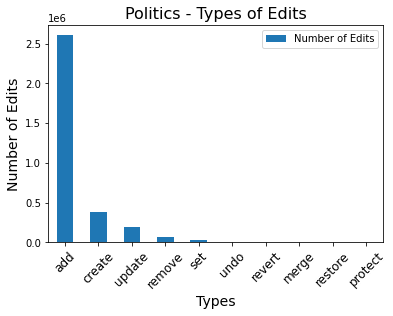

In [43]:
# Plotting the statistics for the proxies in the dataset
ax = ts.plot.bar()

plt.title('Politics - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [44]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[3, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

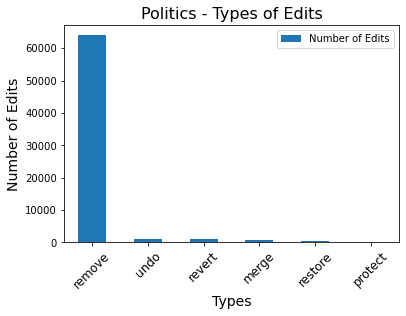

In [45]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('Politics - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [46]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
undo      1062
revert    1028
merge      850
restore    407
protect     24


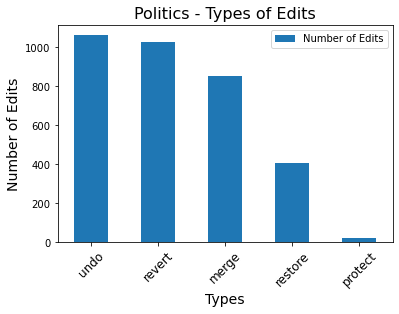

In [47]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('Politics - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

# Statistics for No of Edits

In [49]:
no_of_edits = politics_items.to_numpy()

(array([8.6253e+04, 2.2751e+04, 3.5610e+03, 1.2450e+03, 7.2500e+02,
        1.0860e+03, 2.4320e+04, 4.5600e+02, 4.6300e+02, 4.9800e+02,
        1.1100e+02, 8.9000e+01, 8.4000e+01, 5.8000e+01, 3.5000e+01,
        3.4000e+01, 3.4000e+01, 2.6000e+01, 2.6000e+01, 2.3000e+01,
        1.9000e+01, 1.2000e+01, 1.2000e+01, 1.3000e+01, 9.0000e+00,
        4.0000e+00, 6.0000e+00, 5.0000e+00, 8.0000e+00, 6.0000e+00,
        2.0000e+00, 7.0000e+00, 4.0000e+00, 1.0000e+01, 1.6000e+01,
        3.0000e+00, 3.0000e+00, 5.0000e+00, 5.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.00

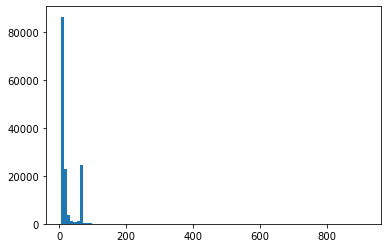

In [75]:
# Exploring distribution of number of edits
plt.hist(no_of_edits, 100)

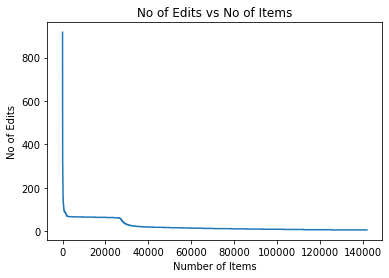

In [85]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

# Grouping by Proxies

In [86]:
reverts = rev["type"].str.contains("revert")
revert_edits = reverts.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [87]:
merges = rev["type"].str.contains("merge")
merge_edits = merges.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [88]:
undos = rev["type"].str.contains("undo")
undo_edits = undos.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [89]:
restores = rev["type"].str.contains("restore")
restore_edits = restores.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [90]:
protects = rev["type"].str.contains("protect")
protect_edits = protects.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [91]:
removes = rev["type"].str.contains("remove")
remove_edits = removes.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [92]:
# Creating a dataframe which will contain qids for items and no of each proxy
proxies = pd.DataFrame({'revert': revert_edits, 'merge': merge_edits, 'undo': undo_edits, 'restore': restore_edits, 
                        'protect': protect_edits, 'remove': remove_edits})

In [93]:
proxies = proxies.reset_index()

In [94]:
proxies.columns

Index(['qid', 'revert', 'merge', 'undo', 'restore', 'protect', 'remove'], dtype='object')

In [95]:
df_editscount.columns

Index(['qid', 'editscount'], dtype='object')

In [96]:
# Adding editscount for each item 
proxies = pd.merge(proxies, df_editscount, how='inner', on=['qid'])

In [97]:
# Counting the number of users per item, that is userscount
rev_users = rev.groupby('qid')['username'].nunique()
# Converting to a dataframe 
df_userscount = pd.DataFrame({'qid':rev_users.index, 'userscount':rev_users.values})

In [98]:
# Adding userscount for each item 
proxies = pd.merge(proxies, df_userscount, how='inner', on=['qid'])

In [100]:
proxies.describe()

,revert,merge,undo,restore,protect,remove,editscount,userscount
count,142051.000000,142051.000000,142051.000000,142051.000000,142051.000000,142051.000000,142051.000000,142051.000000
mean,0.007237,0.005984,0.007476,0.002865,0.000169,0.450465,23.085709,2.569781
std,0.139758,0.081732,0.131438,0.071875,0.012997,1.499924,24.821218,1.840124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,2.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,3.000000
max,15.000000,4.000000,19.000000,8.000000,1.000000,137.000000,917.000000,122.000000


Text(0, 0.5, 'No of Edits')

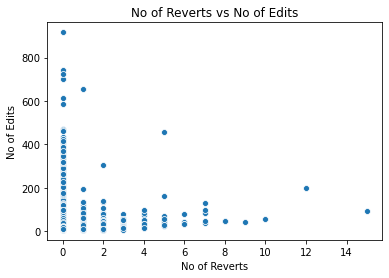

In [101]:
ax = sns.scatterplot(x="revert", y="editscount", data=proxies)
ax.set_title("No of Reverts vs No of Edits")
ax.set_xlabel("No of Reverts")
ax.set_ylabel("No of Edits")

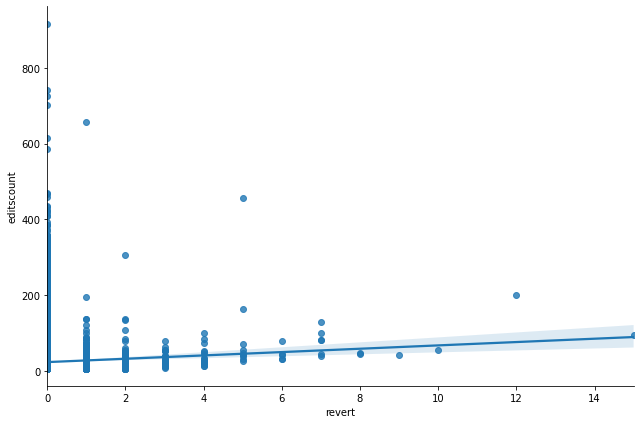

In [106]:
sns.lmplot(x="revert", y="editscount", data=proxies, height=6, aspect=1.5)

In [108]:
corr_matrix = proxies.corr()
corr_matrix

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,0.046129,0.343112,0.433843,0.344251,0.053561,0.024845,0.273225
merge,0.046129,1.000000,0.058745,0.059396,0.025556,0.039227,-0.023985,0.099592
undo,0.343112,0.058745,1.000000,0.277173,0.184700,0.069153,0.034572,0.301307
restore,0.433843,0.059396,0.277173,1.000000,0.233093,0.087414,0.035755,0.215469
protect,0.344251,0.025556,0.184700,0.233093,1.000000,0.013068,0.011019,0.085457
remove,0.053561,0.039227,0.069153,0.087414,0.013068,1.000000,0.190161,0.032988
editscount,0.024845,-0.023985,0.034572,0.035755,0.011019,0.190161,1.000000,-0.135133
userscount,0.273225,0.099592,0.301307,0.215469,0.085457,0.032988,-0.135133,1.000000


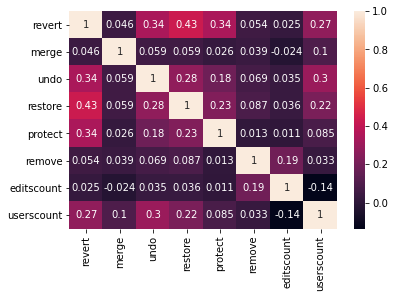

In [109]:
sns.heatmap(corr_matrix, annot=True)

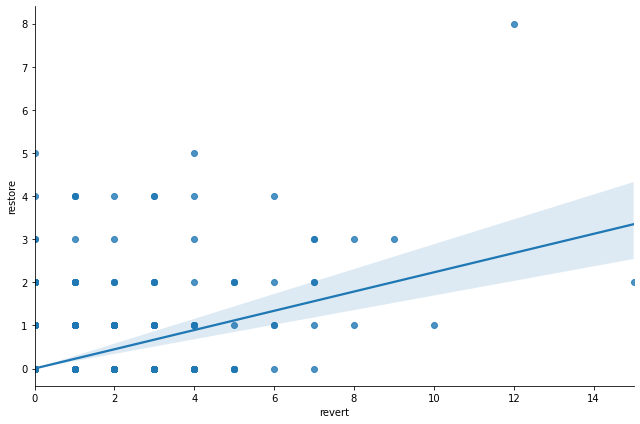

In [110]:
# restore and revert have positive correlation
sns.lmplot(x="revert", y="restore", data=proxies, height=6, aspect=1.5)

Text(0, 0.5, 'No of Edits')

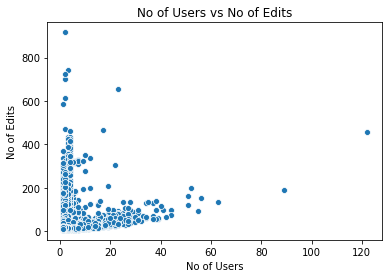

In [111]:
# userscount and editscount have negative correlation 
ax = sns.scatterplot(x="userscount", y="editscount", data=proxies)
ax.set_title("No of Users vs No of Edits")
ax.set_xlabel("No of Users")
ax.set_ylabel("No of Edits")

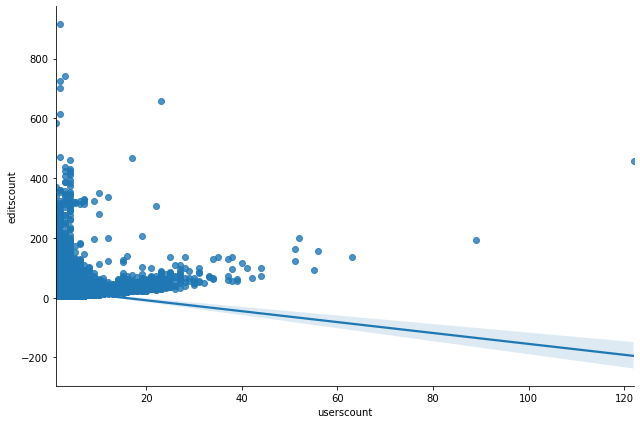

In [112]:
sns.lmplot(x="userscount", y="editscount", data=proxies, height=6, aspect=1.5)

In [113]:
# Removing items with 0 reverts, merges, undos, restores, removes, protects
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0) & 
                   (proxies['remove'] == 0) & (proxies['protect'] == 0)].index
proxies = proxies.drop(to_remove)

In [114]:
proxies.shape

(22100, 9)

In [115]:
# Items which only have edits under remove and are 0 for the remaining proxies
proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)]

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
7,Q2124963,0,0,0,0,0,5,10,1
8,Q2125493,0,0,0,0,0,1,9,4
10,Q2126280,0,0,0,0,0,1,6,3
11,Q2126516,0,0,0,0,0,8,42,3
102,Q2129957,0,0,0,0,0,1,10,4
...,...,...,...,...,...,...,...,...,...
141716,Q28064887,0,0,0,0,0,1,9,3
141759,Q28065753,0,0,0,0,0,1,19,2
141899,Q28086637,0,0,0,0,0,1,21,1
141919,Q28090273,0,0,0,0,0,3,40,1


In [116]:
# Removing items with only edits under remove
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)].index
proxies_without_remove = proxies.drop(to_remove)

In [117]:
proxies_without_remove.shape

(2251, 9)

In [118]:
corr = proxies_without_remove.corr()
corr

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,-0.253887,0.196290,0.352643,0.333038,0.070283,0.254487,0.366865
merge,-0.253887,1.000000,-0.273769,-0.157151,-0.041294,0.002516,-0.106448,-0.170772
undo,0.196290,-0.273769,1.000000,0.160671,0.156071,0.106884,0.342741,0.414393
restore,0.352643,-0.157151,0.160671,1.000000,0.212743,0.170188,0.311490,0.283143
protect,0.333038,-0.041294,0.156071,0.212743,1.000000,0.015270,0.092415,0.120778
remove,0.070283,0.002516,0.106884,0.170188,0.015270,1.000000,0.628021,0.213715
editscount,0.254487,-0.106448,0.342741,0.311490,0.092415,0.628021,1.000000,0.610786
userscount,0.366865,-0.170772,0.414393,0.283143,0.120778,0.213715,0.610786,1.000000


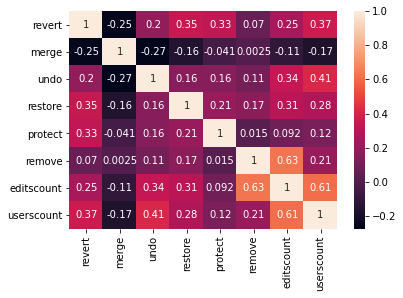

In [119]:
sns.heatmap(corr, annot=True)

# Top 20

## Top 20 Reverts

In [120]:
top20_reverts = proxies_without_remove.nlargest(20, 'revert')

In [121]:
top20_reverts

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
8209,Q517,15,1,5,2,1,12,95,27
8972,Q6294,12,0,3,8,0,14,199,52
8084,Q23,10,0,1,1,0,8,55,15
9756,Q15975,9,1,1,3,1,0,41,13
79415,Q182276,8,0,6,1,1,3,45,13
84455,Q296741,8,0,1,3,1,0,46,9
8080,Q29,7,0,8,3,0,5,130,37
8106,Q77,7,0,2,2,0,0,82,23
8113,Q96,7,0,4,1,0,4,82,31
8296,Q801,7,0,3,2,0,6,99,28


In [122]:
revert_item_labels = ['Napoleon', 'Hillary Clinton', 'George Washington', 'Montesquieu', 'Benito Juárez',
                     'Enrique Peña Nieto', 'Spain', 'Uruguay', 'Mexico', 'Israel', 
                     'Bill Clinton', 'Karl Marx', 'Michelle Bachelet', 'Mahatma Gandhi', 'Che Guevara', 
                     'Ronaldinho', 'Maximilien Robespierre', 'Chile', 'Julius Caesar', 'Dante Alighieri']

# Inserting item labels into revert proxies dataframe
top20_reverts.insert(1, "label", revert_item_labels, True)

In [123]:
top20_reverts

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
8209,Q517,Napoleon,15,1,5,2,1,12,95,27
8972,Q6294,Hillary Clinton,12,0,3,8,0,14,199,52
8084,Q23,George Washington,10,0,1,1,0,8,55,15
9756,Q15975,Montesquieu,9,1,1,3,1,0,41,13
79415,Q182276,Benito Juárez,8,0,6,1,1,3,45,13
84455,Q296741,Enrique Peña Nieto,8,0,1,3,1,0,46,9
8080,Q29,Spain,7,0,8,3,0,5,130,37
8106,Q77,Uruguay,7,0,2,2,0,0,82,23
8113,Q96,Mexico,7,0,4,1,0,4,82,31
8296,Q801,Israel,7,0,3,2,0,6,99,28


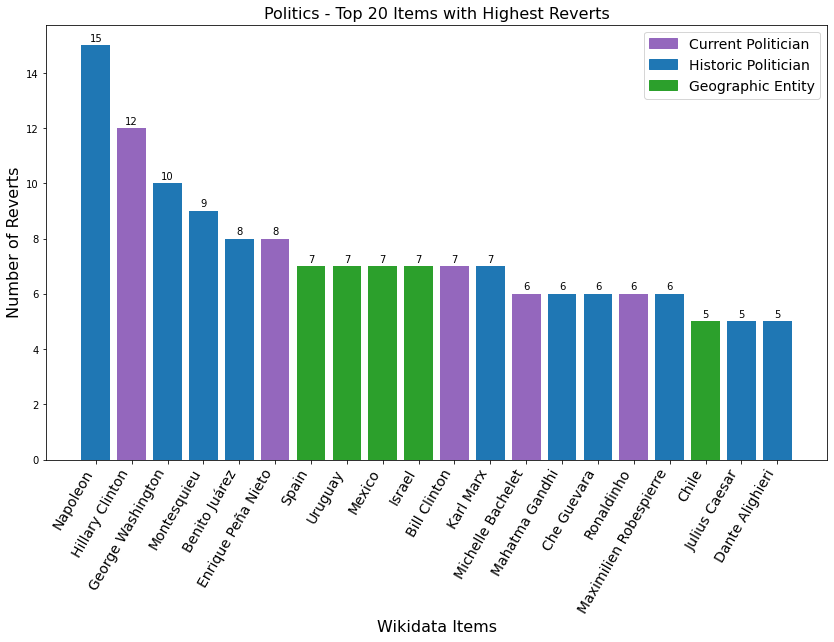

In [125]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_reverts['revert']):
    ax.text(i, r+0.15, str(r), horizontalalignment='center')

colours = ['tab:blue', 'tab:purple', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:purple', 'tab:green', 'tab:green', 'tab:green', 'tab:green',
           'tab:purple', 'tab:blue', 'tab:purple', 'tab:blue', 'tab:blue',
           'tab:purple', 'tab:blue', 'tab:green', 'tab:blue', 'tab:blue']

current_pol = mpatches.Patch(color='tab:purple', label='Current Politician')
hist_pol = mpatches.Patch(color='tab:blue', label='Historic Politician')
geographic_ent = mpatches.Patch(color='tab:green', label='Geographic Entity')

plt.legend(handles=[current_pol, hist_pol, geographic_ent], fontsize=14)

plt.bar(top20_reverts['label'], top20_reverts['revert'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Reverts", fontsize=16)
plt.title("Politics - Top 20 Items with Highest Reverts", fontsize=16)
plt.show()

## Top 20 Merges

In [126]:
top20_merges = proxies_without_remove.nlargest(20, 'merge')

In [127]:
top20_merges

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
64481,Q13202722,0,4,0,0,0,0,10,4
136611,Q20571352,0,4,0,1,0,2,13,5
76318,Q25945398,0,3,0,0,0,0,6,3
136610,Q20571325,0,3,0,0,0,2,9,4
4806,Q2550468,0,2,0,0,0,2,11,2
6266,Q2604568,1,2,0,0,0,0,6,3
8610,Q1865,0,2,0,0,0,0,26,19
12602,Q53880,0,2,0,0,0,0,6,3
12841,Q57553,3,2,1,0,0,1,21,11
13411,Q64224,0,2,0,0,0,2,12,6


In [128]:
merge_item_labels = ['permanent duplicate item-France', 'permanent duplicate item-Turkey', 'template-Internet Movie Database', 'permanent duplicate item-USA', 'Nicolás Ruiz',
                     'Nagarote', 'Kuala Lumpur', 'Firmo', 'Mohammed VI', 'Opfikon', 
                     'Markus Welser', 'Frymburk', 'Allyene', 'template-Page Name Base', 'Quiriego', 
                     'permanent duplicate item-Pyotr Ilyich Tchaikovsky', 'wikimedia category', 'permanent duplicate item-Austria', 'permanent duplicate item-Soviet Union', 'permanent duplicate item-Jesus']

# Inserting item labels into merge proxies dataframe
top20_merges.insert(1, "label", merge_item_labels, True)

In [129]:
top20_merges

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
64481,Q13202722,permanent duplicate item-France,0,4,0,0,0,0,10,4
136611,Q20571352,permanent duplicate item-Turkey,0,4,0,1,0,2,13,5
76318,Q25945398,template-Internet Movie Database,0,3,0,0,0,0,6,3
136610,Q20571325,permanent duplicate item-USA,0,3,0,0,0,2,9,4
4806,Q2550468,Nicolás Ruiz,0,2,0,0,0,2,11,2
6266,Q2604568,Nagarote,1,2,0,0,0,0,6,3
8610,Q1865,Kuala Lumpur,0,2,0,0,0,0,26,19
12602,Q53880,Firmo,0,2,0,0,0,0,6,3
12841,Q57553,Mohammed VI,3,2,1,0,0,1,21,11
13411,Q64224,Opfikon,0,2,0,0,0,2,12,6


Text(0.5, 1.0, 'Politics - Top 20 Items with Highest Merges')

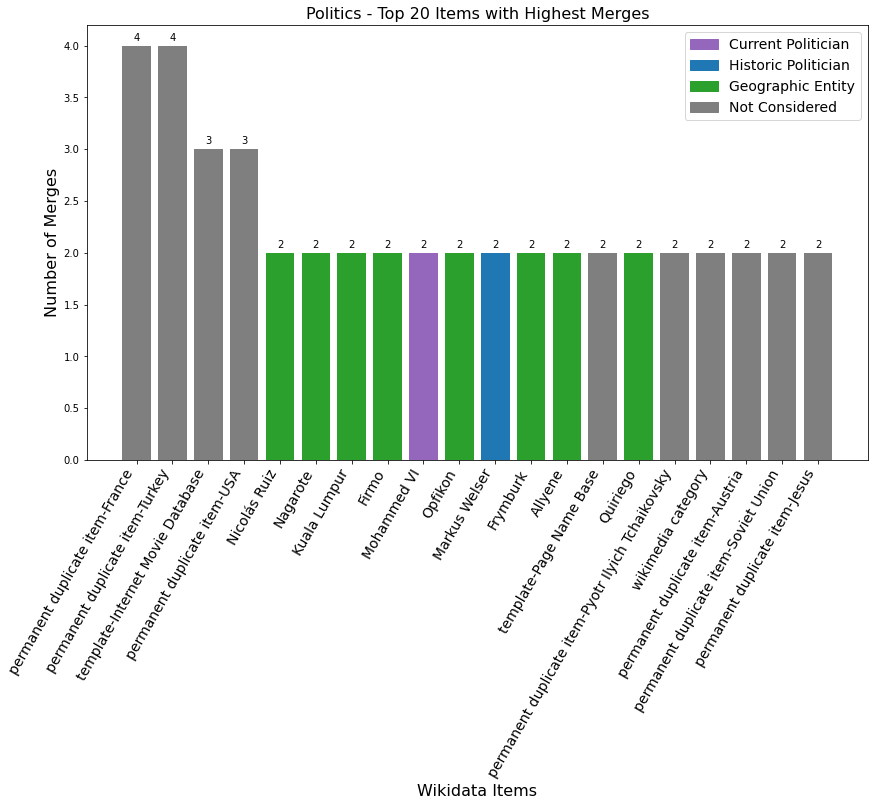

In [132]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_merges['merge']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    

colours = ['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:green',
           'tab:green', 'tab:green', 'tab:green', 'tab:purple', 'tab:green',
           'tab:blue', 'tab:green', 'tab:green', 'tab:gray', 'tab:green',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray']

current_pol = mpatches.Patch(color='tab:purple', label='Current Politician')
hist_pol = mpatches.Patch(color='tab:blue', label='Historic Politician')
geographic_ent = mpatches.Patch(color='tab:green', label='Geographic Entity')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[current_pol, hist_pol, geographic_ent, not_considered], fontsize=14)

plt.bar(top20_merges['label'], top20_merges['merge'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Merges", fontsize=16)
plt.title("Politics - Top 20 Items with Highest Merges", fontsize=16)

## Top 20 Undos

In [133]:
top20_undos = proxies_without_remove.nlargest(20, 'undo')

In [134]:
top20_undos

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
11055,Q22686,5,1,19,2,0,28,456,122
9434,Q11256,5,1,16,0,0,7,164,51
88131,Q433210,1,0,11,1,1,10,109,27
8080,Q29,7,0,8,3,0,5,130,37
8081,Q30,1,1,6,4,1,5,122,51
12665,Q54898,0,0,6,0,0,0,15,4
12726,Q56226,1,0,6,1,0,1,71,15
79415,Q182276,8,0,6,1,1,3,45,13
8127,Q183,0,0,5,0,0,14,115,40
8209,Q517,15,1,5,2,1,12,95,27


In [135]:
undo_item_labels = ['Donald Trump', 'Fidel Castro', 'Rita Barberá Nolla', 'Spain', 'United States of America',
                     'San Cristóbal de La Laguna', 'Kim Jong-un', 'Benito Juárez', 'Germany', 'Napoleon', 
                     'Mahatma Gandhi', 'Muhammad', 'Abraham Cahan', 'no label', 'Mexico', 
                     'Monaco', 'Venezuela', 'Madrid', 'Vladimir Putin', 'Schwyz']

# Inserting item labels into undo proxies dataframe
top20_undos.insert(1, "label", undo_item_labels, True)

In [136]:
top20_undos

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
11055,Q22686,Donald Trump,5,1,19,2,0,28,456,122
9434,Q11256,Fidel Castro,5,1,16,0,0,7,164,51
88131,Q433210,Rita Barberá Nolla,1,0,11,1,1,10,109,27
8080,Q29,Spain,7,0,8,3,0,5,130,37
8081,Q30,United States of America,1,1,6,4,1,5,122,51
12665,Q54898,San Cristóbal de La Laguna,0,0,6,0,0,0,15,4
12726,Q56226,Kim Jong-un,1,0,6,1,0,1,71,15
79415,Q182276,Benito Juárez,8,0,6,1,1,3,45,13
8127,Q183,Germany,0,0,5,0,0,14,115,40
8209,Q517,Napoleon,15,1,5,2,1,12,95,27


Text(0.5, 1.0, 'Politics - Top 20 Items with Highest Undos')

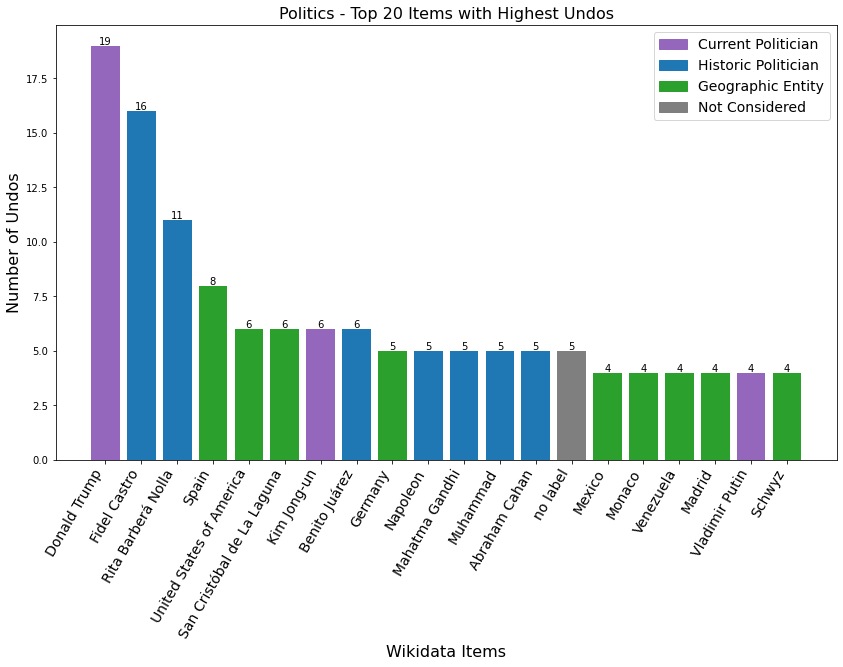

In [159]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_undos['undo']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    
colours = ['tab:purple', 'tab:blue', 'tab:blue', 'tab:green', 'tab:green',
           'tab:green', 'tab:purple', 'tab:blue', 'tab:green', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:gray', 'tab:green',
           'tab:green', 'tab:green', 'tab:green', 'tab:purple', 'tab:green']

current_pol = mpatches.Patch(color='tab:purple', label='Current Politician')
hist_pol = mpatches.Patch(color='tab:blue', label='Historic Politician')
geographic_ent = mpatches.Patch(color='tab:green', label='Geographic Entity')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[current_pol, hist_pol, geographic_ent, not_considered], fontsize=14)

plt.bar(top20_undos['label'], top20_undos['undo'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Undos", fontsize=16)
plt.title("Politics - Top 20 Items with Highest Undos", fontsize=16)

## Top 20 Restores

In [138]:
top20_restores = proxies_without_remove.nlargest(20, 'restore')

In [139]:
top20_restores

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
8972,Q6294,12,0,3,8,0,14,199,52
7075,Q2668161,0,0,0,5,0,13,61,5
11455,Q29179,4,0,2,5,0,3,53,18
8081,Q30,1,1,6,4,1,5,122,51
8195,Q414,3,0,0,4,0,3,80,24
8253,Q717,4,0,4,4,0,2,85,27
8368,Q1001,6,0,5,4,0,1,78,27
9104,Q7747,2,0,4,4,0,12,307,22
9130,Q8385,1,0,0,4,0,38,195,9
9139,Q8605,3,0,0,4,0,4,38,14


In [140]:
restore_item_labels = ['Hillary Clinton', 'John Hagelin', 'Francisco Franco', 'United States of America', 'Argentina',
                     'Venezuela', 'Mahatma Gandhi', 'Vladimir Putin', 'Ostrava', 'Simón Bolívar ', 
                     'Mario Benedetti', 'Miguel López de Legazpi', 'Spain', 'Barack Obama', 'Vladimir Lenin', 
                     'Nelson Mandela', 'Karl Marx', 'Montesquieu', 'no label', 'Enrique Peña Nieto']

# Inserting item labels into restore proxies dataframe
top20_restores.insert(1, "label", restore_item_labels, True)

In [141]:
top20_restores

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
8972,Q6294,Hillary Clinton,12,0,3,8,0,14,199,52
7075,Q2668161,John Hagelin,0,0,0,5,0,13,61,5
11455,Q29179,Francisco Franco,4,0,2,5,0,3,53,18
8081,Q30,United States of America,1,1,6,4,1,5,122,51
8195,Q414,Argentina,3,0,0,4,0,3,80,24
8253,Q717,Venezuela,4,0,4,4,0,2,85,27
8368,Q1001,Mahatma Gandhi,6,0,5,4,0,1,78,27
9104,Q7747,Vladimir Putin,2,0,4,4,0,12,307,22
9130,Q8385,Ostrava,1,0,0,4,0,38,195,9
9139,Q8605,Simón Bolívar,3,0,0,4,0,4,38,14


Text(0.5, 1.0, 'Politics - Top 20 Items with Highest Restores')

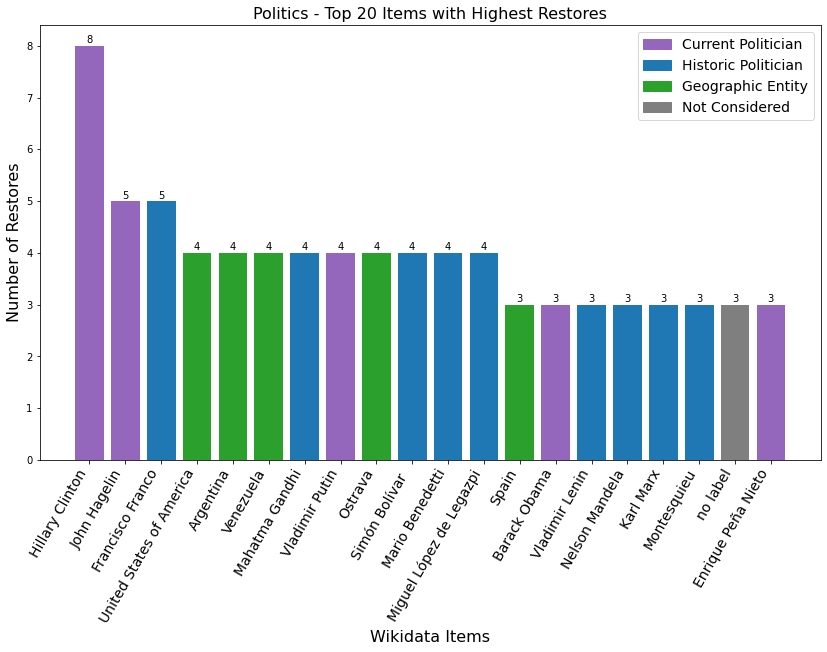

In [160]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_restores['restore']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

    
colours = ['tab:purple', 'tab:purple', 'tab:blue', 'tab:green', 'tab:green',
           'tab:green', 'tab:blue', 'tab:purple', 'tab:green', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:green', 'tab:purple', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:gray', 'tab:purple']

current_pol = mpatches.Patch(color='tab:purple', label='Current Politician')
hist_pol = mpatches.Patch(color='tab:blue', label='Historic Politician')
geographic_ent = mpatches.Patch(color='tab:green', label='Geographic Entity')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[current_pol, hist_pol, geographic_ent, not_considered], fontsize=14)

plt.bar(top20_restores['label'], top20_restores['restore'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Restores", fontsize=16)
plt.title("Politics - Top 20 Items with Highest Restores", fontsize=16)

## Top 20 Edits

In [142]:
top20_edits = proxies_without_remove.nlargest(20, 'editscount')

In [143]:
top20_edits

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
8408,Q1085,1,0,0,1,0,137,657,23
11055,Q22686,5,1,19,2,0,28,456,122
11423,Q28614,0,0,0,1,0,5,338,12
9104,Q7747,2,0,4,4,0,12,307,22
9724,Q14960,0,0,1,0,0,59,279,10
9328,Q9903,0,0,2,0,0,95,208,19
8972,Q6294,12,0,3,8,0,14,199,52
9130,Q8385,1,0,0,4,0,38,195,9
65506,Q15068349,0,0,1,0,0,3,192,89
9434,Q11256,5,1,16,0,0,7,164,51


In [144]:
edit_item_labels = ['Prague', 'Donald Trump', 'Garry Kasparov', 'Vladimir Putin', 'Brno',
                     'Ming dynasty', 'Hillary Clinton', 'Ostrava', 'Andrei Karlov', 'Fidel Castro', 
                     'Kingdom of Denmark', 'France', 'Russia', 'Georgia', 'Netherlands',  
                     'Spain', 'Denmark', 'Michigan', 'United States of America', 'Palana Village']

# Inserting item labels into edit proxies dataframe
top20_edits.insert(1, "label", edit_item_labels, True)

In [145]:
top20_edits

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
8408,Q1085,Prague,1,0,0,1,0,137,657,23
11055,Q22686,Donald Trump,5,1,19,2,0,28,456,122
11423,Q28614,Garry Kasparov,0,0,0,1,0,5,338,12
9104,Q7747,Vladimir Putin,2,0,4,4,0,12,307,22
9724,Q14960,Brno,0,0,1,0,0,59,279,10
9328,Q9903,Ming dynasty,0,0,2,0,0,95,208,19
8972,Q6294,Hillary Clinton,12,0,3,8,0,14,199,52
9130,Q8385,Ostrava,1,0,0,4,0,38,195,9
65506,Q15068349,Andrei Karlov,0,0,1,0,0,3,192,89
9434,Q11256,Fidel Castro,5,1,16,0,0,7,164,51


Text(0.5, 1.0, 'Politics - Top 20 Items with Highest Edits')

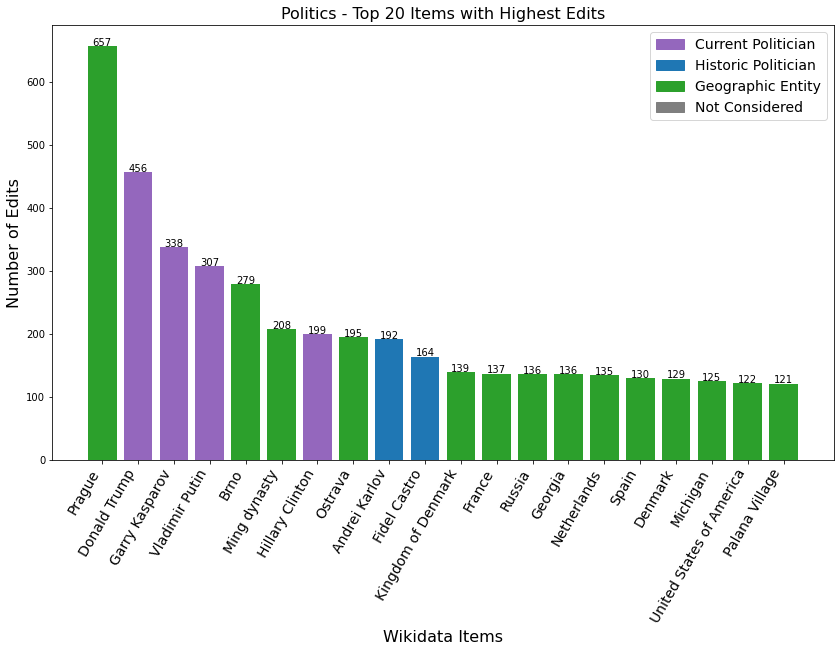

In [161]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_edits['editscount']):
    ax.text(i, r+0.5, str(r), horizontalalignment='center')


colours = ['tab:green', 'tab:purple', 'tab:purple', 'tab:purple', 'tab:green',
           'tab:green', 'tab:purple', 'tab:green', 'tab:blue', 'tab:blue',
           'tab:green', 'tab:green', 'tab:green', 'tab:green', 'tab:green',
           'tab:green', 'tab:green', 'tab:green', 'tab:green', 'tab:green']

current_pol = mpatches.Patch(color='tab:purple', label='Current Politician')
hist_pol = mpatches.Patch(color='tab:blue', label='Historic Politician')
geographic_ent = mpatches.Patch(color='tab:green', label='Geographic Entity')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[current_pol, hist_pol, geographic_ent, not_considered], fontsize=14)

plt.bar(top20_edits['label'], top20_edits['editscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Edits", fontsize=16)
plt.title("Politics - Top 20 Items with Highest Edits", fontsize=16)

## Top 20 Users

In [147]:
top20_users = proxies_without_remove.nlargest(20, 'userscount')

In [148]:
top20_users

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
11055,Q22686,5,1,19,2,0,28,456,122
65506,Q15068349,0,0,1,0,0,3,192,89
23366,Q548733,0,1,1,0,0,4,93,55
8972,Q6294,12,0,3,8,0,14,199,52
8081,Q30,1,1,6,4,1,5,122,51
9434,Q11256,5,1,16,0,0,7,164,51
12790,Q57311,4,0,3,1,0,5,100,44
8105,Q76,0,0,2,3,0,17,100,41
8127,Q183,0,0,5,0,0,14,115,40
11235,Q24313,1,0,0,0,0,1,56,39


In [149]:
user_item_labels = ['Donald Trump', 'Andrei Karlov', 'Vajiralongkorn I of Thailand', 'Hillary Clinton', 'United States of America',
                     'Fidel Castro', 'Juan Manuel Santos', 'Barack Obama', 'Germany', 'Mike Pence', 
                     'Steve Bannon', 'France', 'Paolo Gentiloni', 'Spain', 'Rex Tillerson ',  
                     'Netherlands', 'Denmark', 'Ivanka Trump', 'People\'s Republic of China', 'Japan']

# Inserting item labels into user proxies dataframe
top20_users.insert(1, "label", user_item_labels, True)

In [150]:
top20_users

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
11055,Q22686,Donald Trump,5,1,19,2,0,28,456,122
65506,Q15068349,Andrei Karlov,0,0,1,0,0,3,192,89
23366,Q548733,Vajiralongkorn I of Thailand,0,1,1,0,0,4,93,55
8972,Q6294,Hillary Clinton,12,0,3,8,0,14,199,52
8081,Q30,United States of America,1,1,6,4,1,5,122,51
9434,Q11256,Fidel Castro,5,1,16,0,0,7,164,51
12790,Q57311,Juan Manuel Santos,4,0,3,1,0,5,100,44
8105,Q76,Barack Obama,0,0,2,3,0,17,100,41
8127,Q183,Germany,0,0,5,0,0,14,115,40
11235,Q24313,Mike Pence,1,0,0,0,0,1,56,39


Text(0.5, 1.0, 'Politics - Top 20 Items with Highest Users')

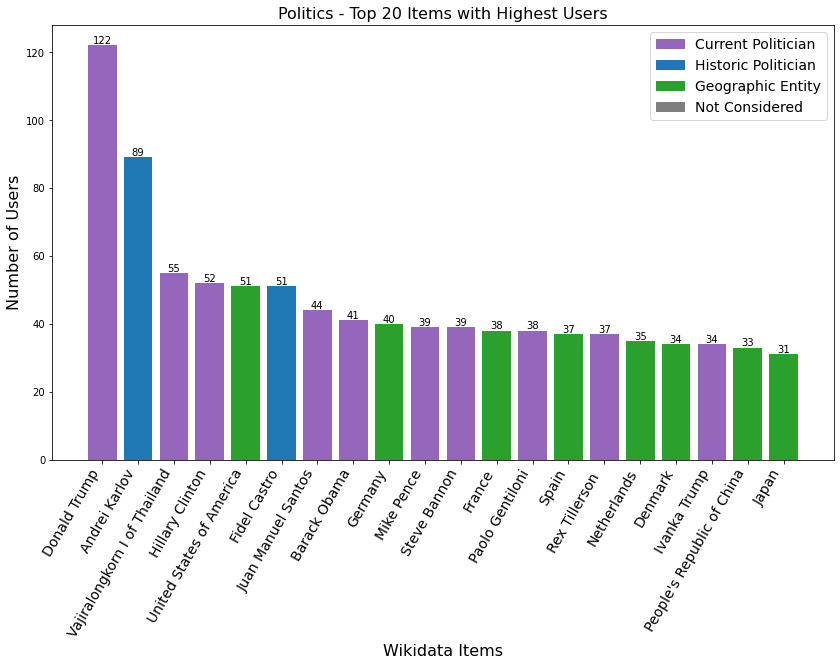

In [162]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_users['userscount']):
    ax.text(i, r+0.5, str(r), horizontalalignment='center')


colours = ['tab:purple', 'tab:blue', 'tab:purple', 'tab:purple', 'tab:green',
           'tab:blue', 'tab:purple', 'tab:purple', 'tab:green', 'tab:purple',
           'tab:purple', 'tab:green', 'tab:purple', 'tab:green', 'tab:purple',
           'tab:green', 'tab:green', 'tab:purple', 'tab:green', 'tab:green']

current_pol = mpatches.Patch(color='tab:purple', label='Current Politician')
hist_pol = mpatches.Patch(color='tab:blue', label='Historic Politician')
geographic_ent = mpatches.Patch(color='tab:green', label='Geographic Entity')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[current_pol, hist_pol, geographic_ent, not_considered], fontsize=14)

plt.bar(top20_users['label'], top20_users['userscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Users", fontsize=16)
plt.title("Politics - Top 20 Items with Highest Users", fontsize=16)

# Selecting Specific Items

In [155]:
# Finding most commonly occurring items in proxies revert, merge, restore and undo
data_frames = [top20_reverts, top20_merges, top20_undos, top20_restores, top20_edits, top20_users]
common_items = pd.concat(data_frames)

In [157]:
common_items_count = common_items['qid'].value_counts()
common_20 = common_items_count.nlargest(20)
print("Items and the number of times they occurred in top 20 reverts, merges, restores and undos")
print(common_20)

Items and the number of times they occurred in top 20 reverts, merges, restores and undos
Q29          5
Q30          4
Q6294        4
Q7747        3
Q1001        3
Q22686       3
Q11256       3
Q35          2
Q15068349    2
Q717         2
Q296741      2
Q182276      2
Q8385        2
Q517         2
Q183         2
Q55          2
Q96          2
Q9061        2
Q15975       2
Q142         2
Name: qid, dtype: int64


Based on the above information and using assumption-3 that items with a diverse range of proxies would be interesting to look at, the following items were selected.

- Donald Trump
- Hillary Clinton
- Fidel Castro
- Napoleon
- Vladimir Putin
- Mahatma Gandhi

In [158]:
# Storing the revisions of the selected items in CSV files
# rev[rev['qid'] == 'Q22686'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/politics/DonaldTrump_Q22686.csv')
# rev[rev['qid'] == 'Q6294'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/politics/HillaryClinton_Q6294.csv')
# rev[rev['qid'] == 'Q11256'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/politics/FidelCastro_Q11256.csv')
# rev[rev['qid'] == 'Q517'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/politics/Napoleon_Q517.csv')
# rev[rev['qid'] == 'Q7747'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/politics/VladimirPutin_Q7747.csv')
# rev[rev['qid'] == 'Q1001'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/politics/MahatmaGandhi_Q1001.csv')